In [67]:
import pandas as pd
import numpy as np
import click
import logging
from pathlib import Path
from dotenv import find_dotenv, load_dotenv
from src.timer import timer
import datetime as dt
import re
import os
from metpy import calc
from metpy.units import units
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
cf.set_config_file(offline=True)

# lambda function to get wind velocity module
get_wind_velmod = lambda x : float(calc.wind_speed(
    x.U * units.meter/units.second, 
    x.V * units.meter/units.second
).magnitude)


def reduce_mem_usage(df):
    """ 
    Iterate through all the columns of a dataframe and modify the data type
    to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
   
    return df


def import_data(file):
    """Creates a dataframe and optimize its memory usage."""
    df = pd.read_csv(file, keep_date_col=True)
    df = reduce_mem_usage(df)  
                                                          
    return df


def add_new_cols(new_cols, df):
    """Adds new colums to a data frame."""
    for col in new_cols:
        df[col] = np.nan   


def split_data_by_date(date, X, y):
    """
    It splits X and y sets by a 'Time' value 
    into sets for training and testing. 
        - Return: a dictionary with the four sets
                  (X_train, y_train, X_test, y_test)
    """
    sets = {}
    date_cut = dt.datetime.strptime(date, '%Y-%m-%d %H:%M:%S')
    
    X_test = X[X['Time'] > date_cut]
    X_train = X[X['Time'] <= date_cut]
    y_train = y[y.ID.isin(X_train.ID)]
    y_test = y[y.ID.isin(X_test.ID)]
    
    sets['X_train'] = X_train
    sets['X_test'] = X_test
    sets['y_train'] = y_train
    sets['y_test'] = y_test
    
    return sets


def input_missing_values(df, cols):
    """Imputes missing values based on the gap time between forecasted timestamp and NWP run."""
    regex = 'NWP(?P<NWP>\d{1})_(?P<run>\d{2}h)_(?P<fc_day>D\W?\d?)_(?P<weather_var>\w{1,4})'
    p = re.compile(regex)  
    
    NWP_met_vars_dict = {
        '1': ['U','V','T'],
        '2': ['U','V'],
        '3': ['U','V','T'],
        '4': ['U','V','CLCT']
    }
    
    for col in reversed(cols):
        m = p.match(col)
        col_name = 'NWP' + m.group('NWP') + '_' +  m.group('run') + '_' + m.group('fc_day') + '_' + m.group('weather_var')

        for key, value in NWP_met_vars_dict.items():
            for i in value:
                if m.group('NWP') == key and m.group('weather_var') == i:
                    df['NWP'+ key + '_' + i] = df['NWP'+ key + '_' + i].fillna(df[col_name])
    
    return df


def interpolate_missing_values(df, cols, index):
    """Imputes those missing values due to the NWP's frequency in data providing."""
    df.index = df[index]
    del df[index]
    
    for var in cols:
        df[var].interpolate(method='time', inplace=True, limit=2, limit_direction='both')
    df.reset_index(inplace=True)
    
    return df

In [72]:
input_filepath = "../data/raw/" 
output_filepath = "../data/interim/"

# Import raw data
X_train = import_data(input_filepath + 'X_train_raw.csv')
X_train['Time'] = pd.to_datetime(X_train['Time'], format='%d/%m/%Y %H:%M')
y_train = import_data(input_filepath + 'y_train_raw.csv')

# Wind farm list
WF_lst = X_train['WF'].unique()

# New columns that will be added to data sets
new_cols = ['NWP1_U','NWP1_V','NWP1_T','NWP2_U','NWP2_V','NWP3_U',
        'NWP3_V','NWP3_T','NWP4_U','NWP4_V','NWP4_CLCT']

# Columns that need interpolating missing values
col_list = ['NWP2_U','NWP2_V','NWP3_U','NWP3_V','NWP3_T']

#for WF in WF_lst:
# Make a copy of the data to not losing its initial format
X_train_cpy = X_train.copy()
y_train_cpy = y_train.copy()

    
# Row selection by WF
X_train_cpy = X_train_cpy[X_train_cpy['WF'] == 'WF1']

# Save observations identification
ID_train = X_train_cpy['ID']

# Row selection for y_train
y_train_cpy = y_train_cpy.loc[ID_train.values - 1]

# Add new columns to X_train and X_test
add_new_cols(new_cols, X_train_cpy)

# Impute missing values
X_train_cpy = input_missing_values(X_train_cpy, X_train.columns[3:])
interpolate_missing_values(X_train_cpy, col_list, 'Time')

# Select the best NWP predictions for weather predictors
X_train_cpy['U'] = X_train_cpy.NWP1_U
X_train_cpy['V'] = X_train_cpy.NWP1_V
X_train_cpy['T'] = X_train_cpy.NWP3_T
X_train_cpy['CLCT'] = X_train_cpy.NWP4_CLCT

X_train_cpy = X_train_cpy[['ID','Time','U','V','T','CLCT']]

Memory usage of dataframe is 29.94 MB
Memory usage after optimization is: 7.72 MB
Decreased by 74.2%
Memory usage of dataframe is 0.57 MB
Memory usage after optimization is: 0.21 MB
Decreased by 62.5%


In [73]:
X_train_cpy['Production'] = list(y_train_cpy['Production'])

# Calculate wind velocity module
X_train_cpy['vel'] = X_train_cpy.apply(get_wind_velmod, axis=1)

In [74]:
# Calculate wind velocity module
X_train_cpy['vel'] = X_train_cpy.apply(get_wind_velmod, axis=1)

# Add 'Production' column
X_train_cpy['Production'] = list(y_train_cpy['Production'])

In [75]:
X_train_cpy.head()

,ID,Time,U,V,T,CLCT,Production,vel
0,1,2018-05-01 01:00:00,-2.248047,-3.257812,286.000000,82.5625,0.020004,3.958163
1,2,2018-05-01 02:00:00,-2.433594,-1.446289,286.000000,100.0000,0.070007,2.830924
2,3,2018-05-01 03:00:00,3.365234,-3.060547,286.000000,98.3750,0.219971,4.548818
3,4,2018-05-01 04:00:00,3.707031,-6.218750,285.666667,94.8750,0.389893,7.239816
4,5,2018-05-01 05:00:00,3.812500,-5.445312,285.333333,95.8750,0.409912,6.647299


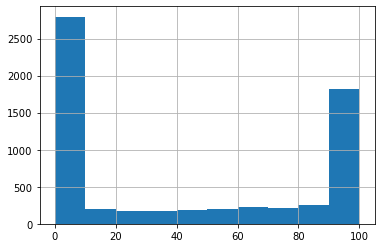

In [76]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, 
                    cols=1, 
                    start_cell="top-left",
                    x_title='X',
                    y_title='Y')

fig.add_trace(go.Scatter(x=X_train_cpy['U'], y=X_train_cpy['T'], mode="markers", marker=dict(size=3)),
              row=1, col=1)


fig.update_layout(height=700, width=800)

fig.show()

X_train_cpy['CLCT'].hist()

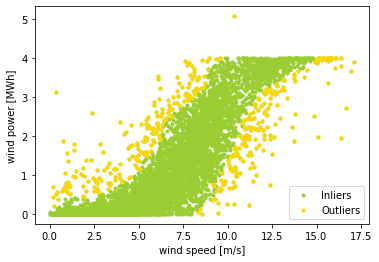

In [36]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
# Add 'Production' column
X_train_cpy['Production'] = list(y_train_cpy['Production'])

# Calculate wind velocity module
X_train_cpy['vel'] = X_train_cpy.apply(get_wind_velmod, axis=1)

# Build data matrix
X1 = X_train_cpy['vel'].values.reshape(-1,1)
X2 = X_train_cpy['Production'].values.reshape(-1,1)
X = np.concatenate((X1,X2), axis=1)

# Using DBSCAN to find outliers
outlier_detection = DBSCAN(eps = 0.18, metric = "mahalanobis", algorithm = 'brute', min_samples = 20, n_jobs = -1)
clusters = outlier_detection.fit_predict(X)
outliers = np.where(clusters == -1)[0]

# Plot outliers
plt.scatter(*X.T, color='yellowgreen', marker='.', label='Inliers')
plt.scatter(*X[outliers].T, color='gold', marker='.', label='Outliers')
plt.legend(loc='lower right')
plt.xlabel("wind speed [m/s]")
plt.ylabel("wind power [MWh]")
plt.show()

In [37]:
X_ = X_train_cpy[['vel','Production']]

In [38]:
from operational_analysis.toolkits import filters
from operational_analysis.toolkits import power_curve

def plot_flagged_pc(ws, p, flag_bool, alpha):
    plt.scatter(ws, p, s = 3, alpha = alpha)
    plt.scatter(ws[flag_bool], p[flag_bool], s = 3, c = 'red')
    plt.xlabel('Wind speed (m/s)')
    plt.ylabel('Power (kW)')
    plt.show()

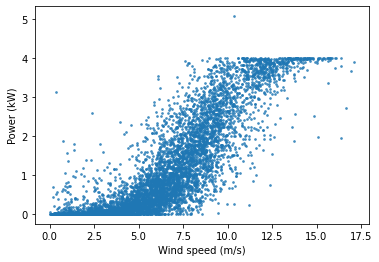

In [39]:
plot_flagged_pc(X_.vel, X_.Production, np.repeat('True', len(X_.vel)), 0.7)

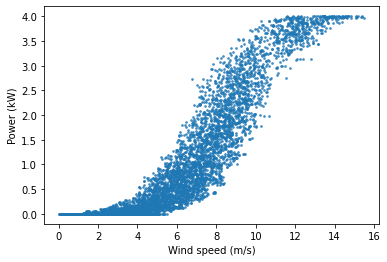

In [40]:
# top-curve stacked outliers
top_stacked = filters.window_range_flag(X_.Production, 0.97*X_.Production.max(), X_.Production.max(), X_.vel, 12.5, 2000.)

# sparse outliers
max_bin = 0.97*X_.Production.max()
sparse_outliers = filters.bin_filter(X_.Production, X_.vel, 0.05, X_.Production.std(), 'median', 0.2, max_bin, 'std', 'all')

# bottom-curve stacked outliers
bottom_stacked = filters.window_range_flag(X_.vel, 5.5, 40, X_.Production, 0.05, 2000.)

# deleting outliers
X_.vel = X_.vel[(~top_stacked) & (~sparse_outliers) & (~bottom_stacked)]
X_.Production = X_.Production[(~top_stacked) & (~sparse_outliers) & (~bottom_stacked)]
plot_flagged_pc(X_.vel, X_.Production, np.repeat('True', len(X_.vel)), 0.7)

In [41]:
X

array([[4.44752606, 0.        ],
       [5.13474594, 0.        ],
       [5.11838691, 0.07000732],
       ...,
       [3.75772252, 0.13000488],
       [3.07444382, 0.01000214],
       [3.40735969, 0.        ]])

In [1]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

In [2]:
iris = load_iris()

In [7]:
X = iris.data[:, (2,3)] # petal length, petal width
y = (iris.target == 0).astype(np.int) # Iris setosa?


In [8]:
per_clf = Perceptron()
per_clf.fit(X,y)

Perceptron()

In [9]:
y_pred = per_clf.predict([[2, 0.5]])

In [11]:
per_clf.predict([[0.2, 0.1]])

array([1])

In [12]:
import tensorflow as tf

ImportError: Traceback (most recent call last):
  File "C:\Users\Quark\.conda\envs\TFM-env\lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 64, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed: No se puede encontrar el módulo especificado.


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/errors

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

In [1]:
import numpy as np

In [7]:
a = np.array([True, False]).reshape(-1,1)
b = np.array([True, True, False, True, False]).reshape(-1,1)

In [8]:
np.concatenate()

TypeError: only integer scalar arrays can be converted to a scalar index